In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, accuracy_score
from utils import read_table


In [189]:
selected_columns = ['playerID', 'yearID', 'salary']
# some players have multiple teams in the same year... what do we do with that in terms of salary prediction?
df_Salaries = read_table("Salaries", selected_columns = selected_columns)

df_Salaries = df_Salaries[df_Salaries["yearID"] > 2000.0]
df_Salaries = df_Salaries.reset_index()
salaries = df_Salaries["salary"].to_list()
years = df_Salaries["yearID"].to_list()
n = len(salaries)

In [190]:
# Here we replace salary with salary_z, which just computes the z distance between the salary and the average salary that year
average_by_year = df_Salaries.groupby('yearID')['salary'].mean().to_dict()
std_by_year = df_Salaries.groupby('yearID')['salary'].std().to_dict()

z_distance = []
for i in range(n):
    year = years[i]
    salary = salaries[i]
    z_distance.append((salary - average_by_year[year])/std_by_year[year])
df_Salaries["salary_z"] = pd.Series(z_distance)

df_Salaries = df_Salaries.drop(columns=["salary"])

In [191]:
df_Stats = read_table("PlayerBatting")
df = pd.merge(df_Salaries, df_Stats, on=['playerID', 'yearID'], how='inner')

y = df["salary_z"]
X = df.drop(columns=["index", "salary_z","playerID", "yearID", "Unnamed: 0", "stint", "teamID", "debut", "birthYear", "lgID"])

bad_features = ["CS", "SF", "3B", "GIDP", "SB", "2B", "HBP", "SO", "H", "current_age", "height", "weight", "SH"]
# X = X.drop(columns=bad_features)


In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [193]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [194]:
mean_absolute_error(y_pred, y_test)

0.6075411051202114

In [195]:
param_grid = {
    'n_estimators': [51, 101, 151],
    'max_depth': [2, 4, 9, 13],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [196]:
model = RandomForestRegressor()

# Set up the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [197]:
mean_absolute_error(y_pred, y_test)

0.5051299324803219

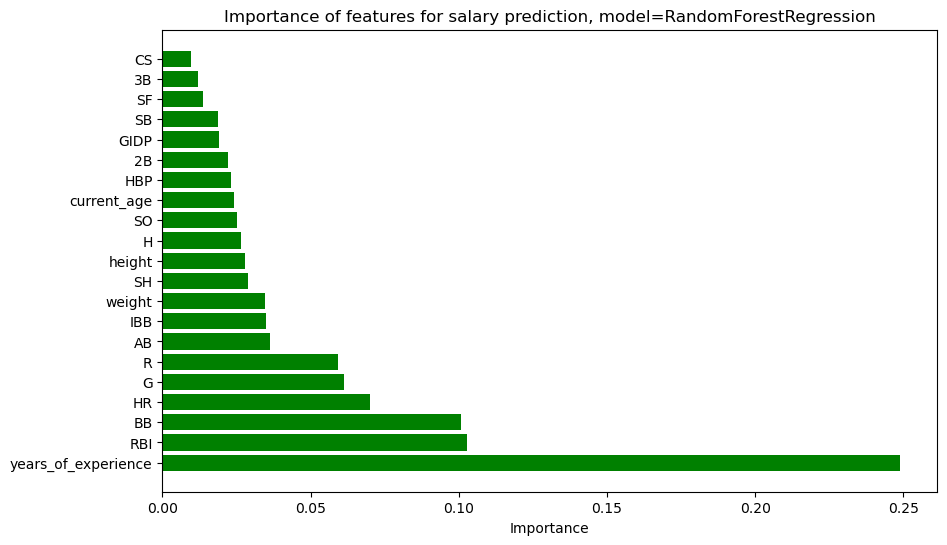

In [204]:
importances = model.feature_importances_
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color="green")
plt.xlabel('Importance')
plt.title('Importance of features for salary prediction, model=RandomForestRegression')
plt.show()